In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

import pandas as pd
idx = pd.IndexSlice

import scipy.optimize as opt
from scipy import stats

from tqdm import tqdm

# these functions are within the 'inorg_b' helper module.
from inorg_b import load
from inorg_b.model import predfn, fitfn
from inorg_b.plots import model_vs_data
from inorg_b.helpers import A11_2_d11, d11_2_A11, err

import corner

plt.rcParams['figure.dpi'] = 150

Populating the interactive namespace from numpy and matplotlib


# Load Data

In [2]:
rd = load.processed(alpha_sol=1.026)

# Model fitting

In [3]:
# note parameter order: (Kb3, Kf3, Kb4, Kf4, logRb)
initial_guess = (200, 5, 2000, 20, -6.2218)

## Prepare model variables for fit

In [4]:
# prepare fitting variables
cind = idx[:, 'Uchikawa', :]

# Precipitation Rate
logRp = (rd.loc[cind, ('Solid', 'logR')]).values
Rp = 10**logRp
# Solution BO3/C and BO4/CO3 ratios
rL3 = (rd.loc[cind, ('pitzer', 'BOH3')] / rd.loc[cind, ('pitzer', 'C')]).astype(float).values
rL4 = (rd.loc[cind, ('pitzer', 'BOH4_free')] / rd.loc[cind, ('pitzer', 'CO3')]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = (rd.loc[cind, ('pitzer', 'B')] / rd.loc[cind, ('pitzer', 'C')]).astype(float).values
# Isotopic content of each B species
ABO3 = d11_2_A11(rd.loc[cind, ('Solution', 'd11BO3 (permil vs NIST951)')].astype(float).values)
ABO4 = d11_2_A11(rd.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values)
# Borate d11B for EpsilonB calculation
dBO4 = rd.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values

# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = rd.loc[cind, ('Solid', 'LambdaB')].astype(float).values
EpsilonB = rd.loc[cind, ('Solid', 'EpsilonB')].astype(float).values

# Uncertainties on the measured variables
LambdaB_err = err(rd.loc[cind, ('Solid', 'LambdaB_eprop')].values)
EpsilonB_err = err(rd.loc[cind, ('Solid', 'EpsilonB_eprop')].values)

# normalised to their mean, to make them comparable
LambdaB_err_norm = (LambdaB_err / LambdaB_err.mean())
EpsilonB_err_norm = (EpsilonB_err / EpsilonB_err.mean())

# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

## Parameter Optimisation

Use a Non-Linear Least Square Nelder-Mead algorithm to find the optimal parameters of $^3K_b$, $^3K_f$, $^4K_b$, $^4K_f$, and $\log_{10}(R_b)$. The absolute optimised parameter values are sensitive to the starting state of the optimisiation ($x_0$). This initial 'rough' fitting served to provide 'ball-park' parameter values, ignoring the measurement uncertainties.

In [106]:
fit = opt.minimize(fitfn, x0=initial_guess,
                   method='Nelder-Mead', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

Optimization terminated successfully.
         Current function value: 2.377732
         Iterations: 1085
         Function evaluations: 1778


In [107]:
np.save('fit_params', fit.x)

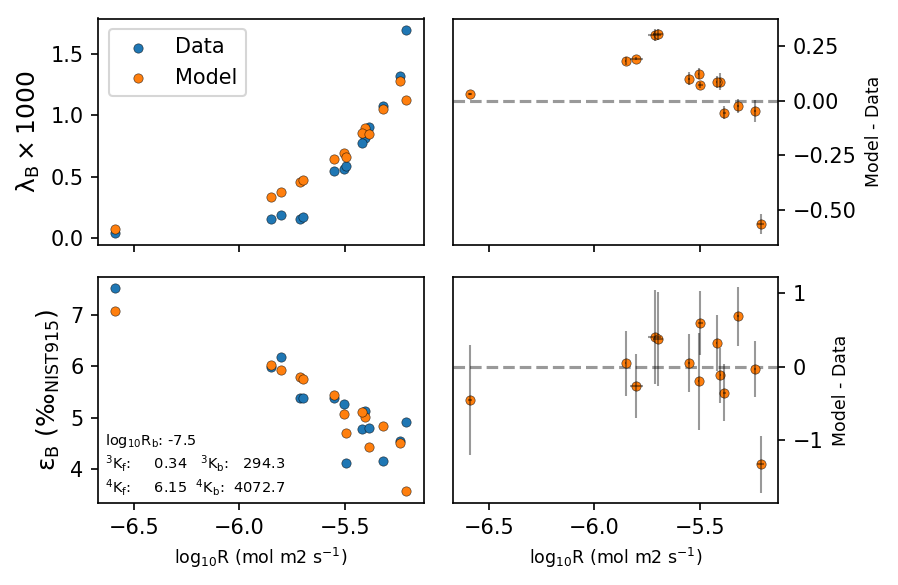

In [108]:
fig, axs = model_vs_data(fit.x, rd)

## Bootstrap Parameter Uncertainties

Calculate Parameter 95% confidence intervals by Bootstrap uncertainty resampling.

In [8]:
# Warning - this runs at ~5 iterations/second on a dual core i7 processor.
# Might take a while if n is high (10000 = ~30 min)!

n = 10000

# initialise variables for outputs
fits = []

# for reproducibility purposes, set the random state
np.random.seed(123)
# initialise iterative initial guess parameter
i_initial_guess = np.array(initial_guess)

# bootstrap resampling and fitting
for i in tqdm(range(n), total=n):
    # resample the uncertainties in the data and create new data to fit
    i_LambdaB = LambdaB + np.random.randn(LambdaB.size) * LambdaB_err
    i_EpsilonB = EpsilonB + np.random.randn(EpsilonB.size) * EpsilonB_err
    # Note: there are uncertainties in other parameters, but they are relatively
    # small compared to the B measurement errors, so we haven't included these.
    
    success = False  # flag indicating fit convergence.
    while not success:  # while loop catches failed model fits.
        # modify initial guess in each iteration
        # check to keep initial logRb starting point in reasonable bounds, and all starting Ks > 0.
        logRb = 0
        while ((logRb < -8.2) | (logRb > -5.2)) & all(i_initial_guess[:-1] > 0):
            i_initial_guess = initial_guess * np.random.normal(1, [.25, .25, .25, .25, .1])
            logRb = i_initial_guess[-1]

        # fit the resampled data with a random starting parameter set and initial guess
        i_fit = opt.minimize(fitfn, x0=i_initial_guess, 
                             method='Nelder-Mead', options={'maxiter': 2000},
                             args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                                   i_LambdaB, i_EpsilonB, 1, 1, lambda_bias))
        
        # check to make sure the fit has converged
        success = i_fit.success
    
    # record the optimised parameters.
    fits.append(i_fit.x)

fits = np.array(fits)

100%|██████████| 10000/10000 [30:29<00:00,  5.46it/s]


In [10]:
# remove impossible fits: where any parameter is less than zero, and logRb is outside reasonable bounds.
excl = ~np.any(fits[:, :-1] < 0, 1) & (fits[:, -1] < -4.2) & (fits[:, -1] > -9.2)
fits = fits[excl,:]

print('Total Excluded: {:.0f}'.format(sum(~excl)))

Total Excluded: 66


In [104]:
# save bootstrap output to save time later
np.save('bootstrap', fits)

In [53]:
# calculate parameter confidence intervals
CI_limit = 66
loq, hiq = np.apply_along_axis(np.percentile, 0, fits, q=[50 - CI_limit / 2, 50 + CI_limit / 2])

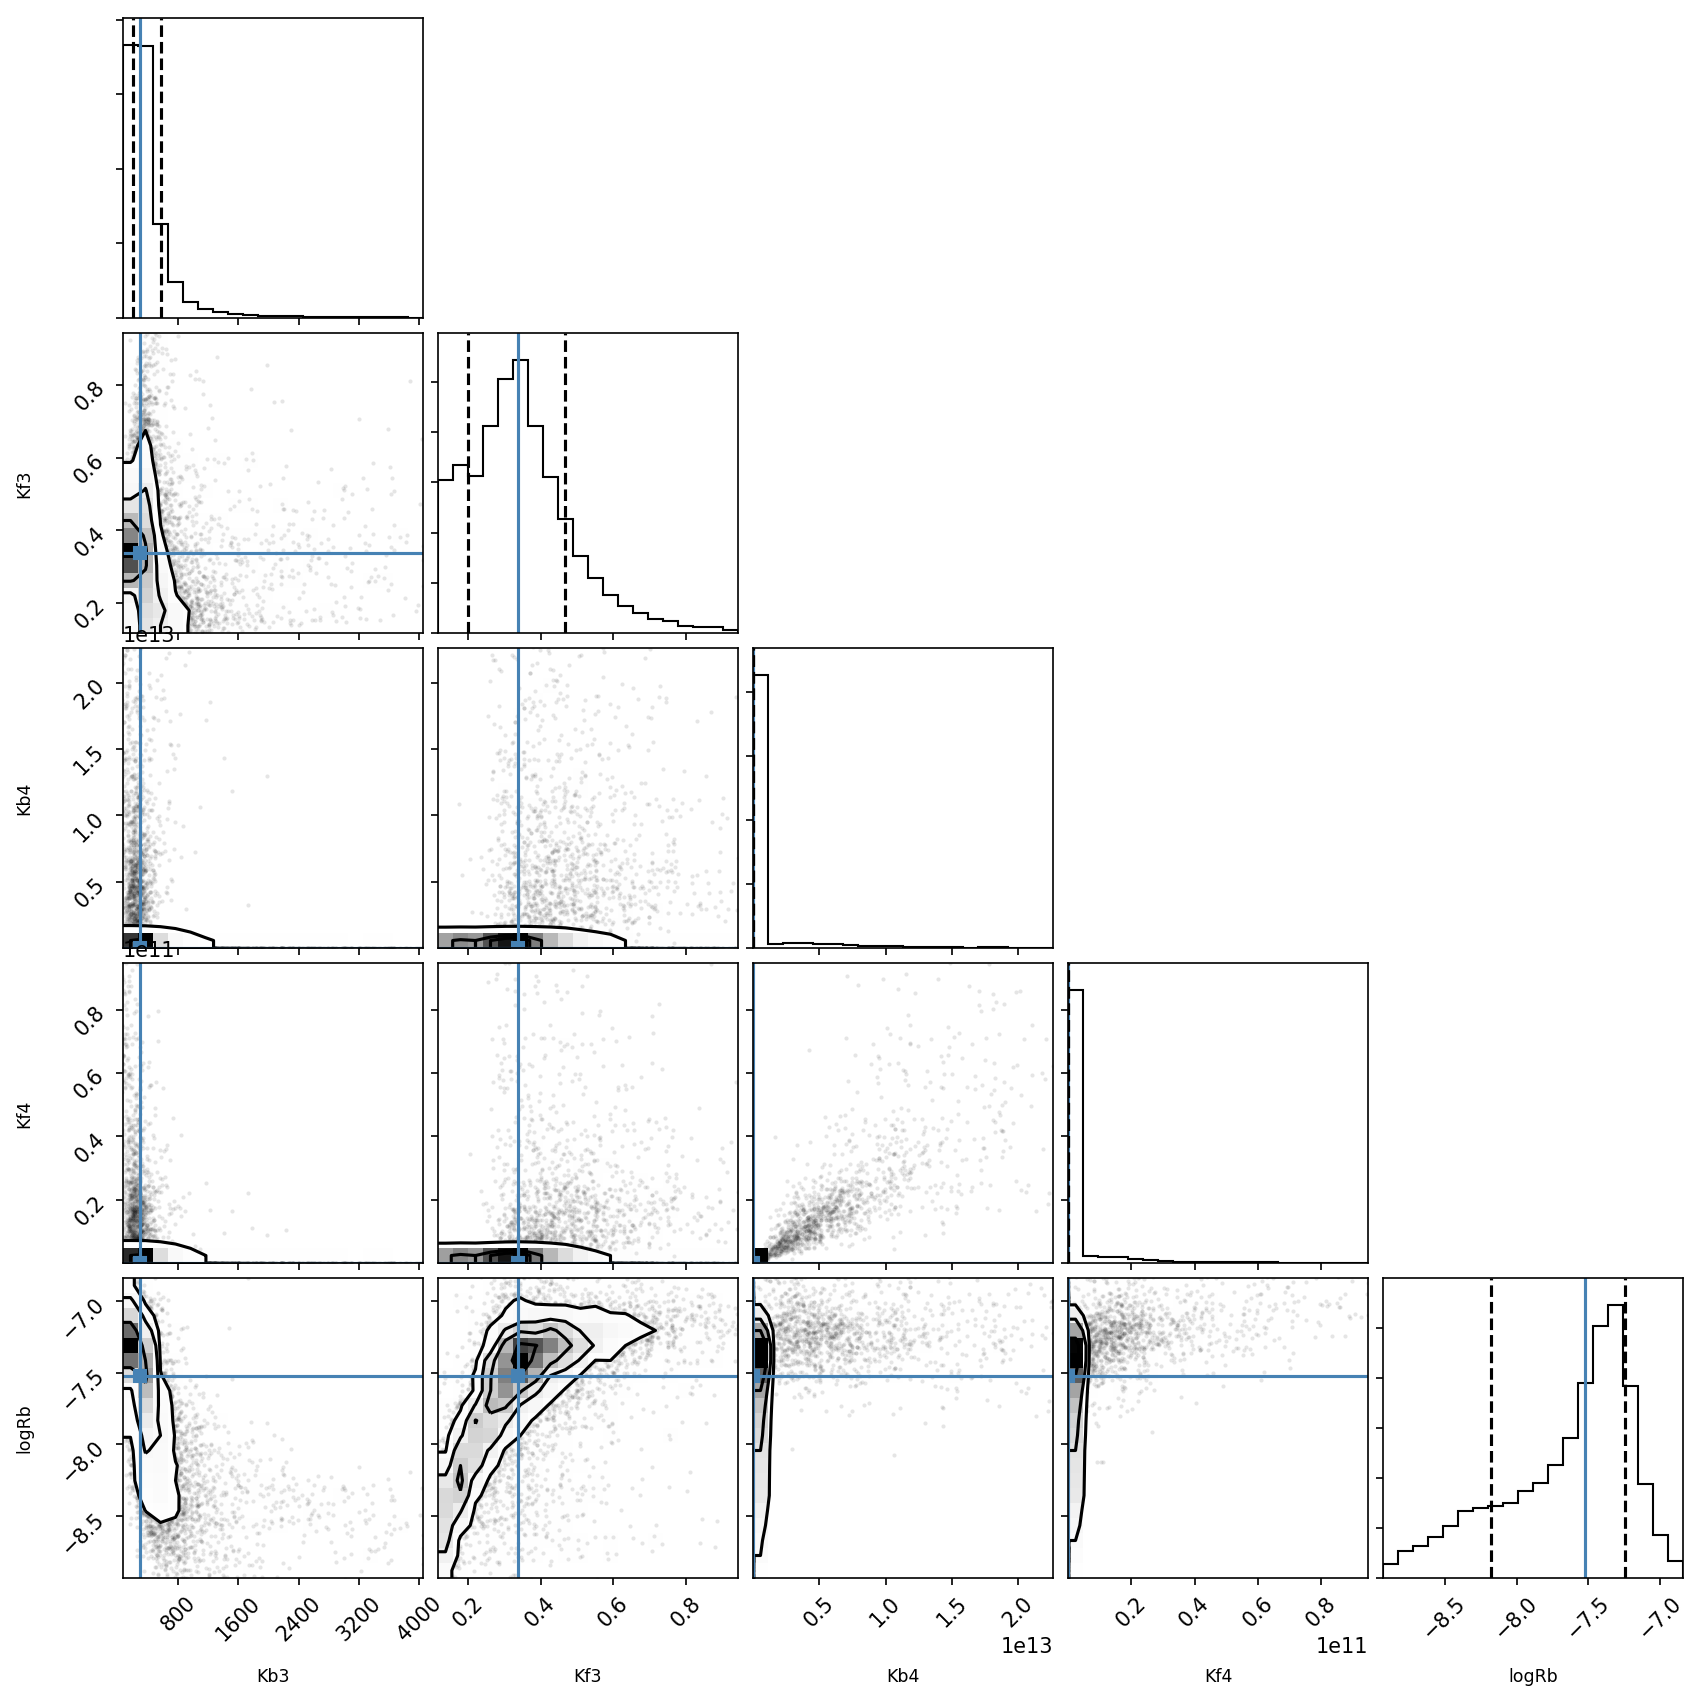

In [99]:
# plot fitted parameters and confidence intervals
par = ['Kb3', 'Kf3', 'Kb4', 'Kf4', 'logRb']
ranges = np.apply_along_axis(np.percentile, 0, fits, q=[1, 99]).T
p = corner.corner(fits, labels=par, truths=fit.x, quantiles=[(50 - CI_limit / 2) / 100, (50 + CI_limit / 2) / 100],
                  range=ranges)

In [93]:
# calculate model for each parameter combination
lam = []
eps = []

Rps = np.sort(Rp)

for p in fits:
    tlam, teps = predfn(*p,
                        Rp=Rp, rL3=rL3, rL4=rL4, B_DIC=B_DIC, ABO3=ABO3, ABO4=ABO4, dBO4=dBO4)
    
    lam.append(tlam)
    eps.append(teps)

lam = np.array(lam)
eps = np.array(eps)

# calculate 95% intervals for each point
lams = np.apply_along_axis(np.percentile, 0, lam, q=[2.5,50,97.5])
epss = np.apply_along_axis(np.percentile, 0, eps, q=[2.5,50,97.5])

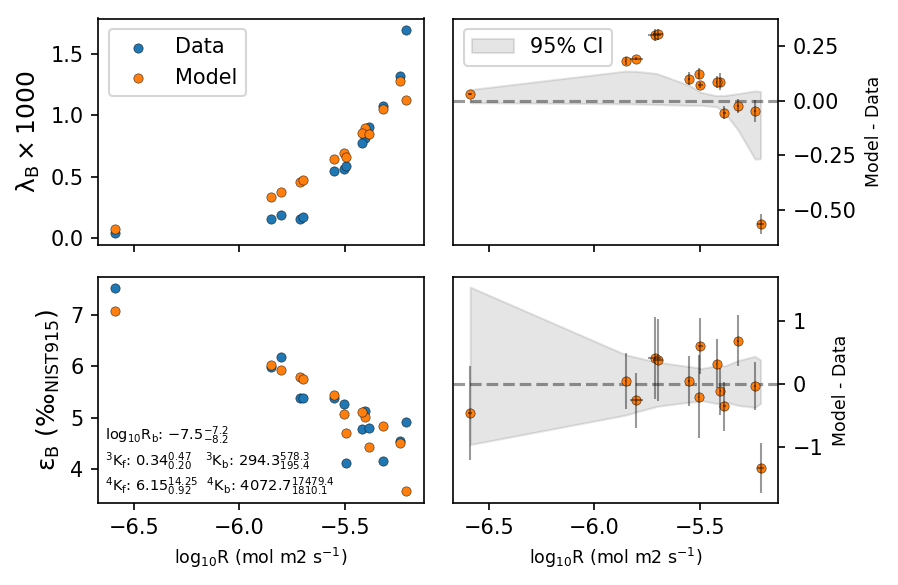

In [101]:
fig, axs = model_vs_data(fit.x, rd, param_CIs=np.vstack([loq, hiq]).T)

((ax1, rx1), (ax2, rx2)) = axs

# 95% credible limits on residual plots
ind = np.argsort(logRp)

rx1.fill_between(logRp[ind],
                 (lams[2] - lams[1])[ind],
                 (lams[0] - lams[1])[ind],
                 color=(0,0,0,0.1), zorder=-1, label='95% CI')
rx1.legend(loc='upper left')

rx2.fill_between(logRp[ind],
                 (epss[2] - epss[1])[ind],
                 (epss[0] - epss[1])[ind],
                 color=(0,0,0,0.1), zorder=-1)

fig.savefig('../../Figures/Fig5-model_vs_data.pdf')

# Residual as fn of Solution Chem

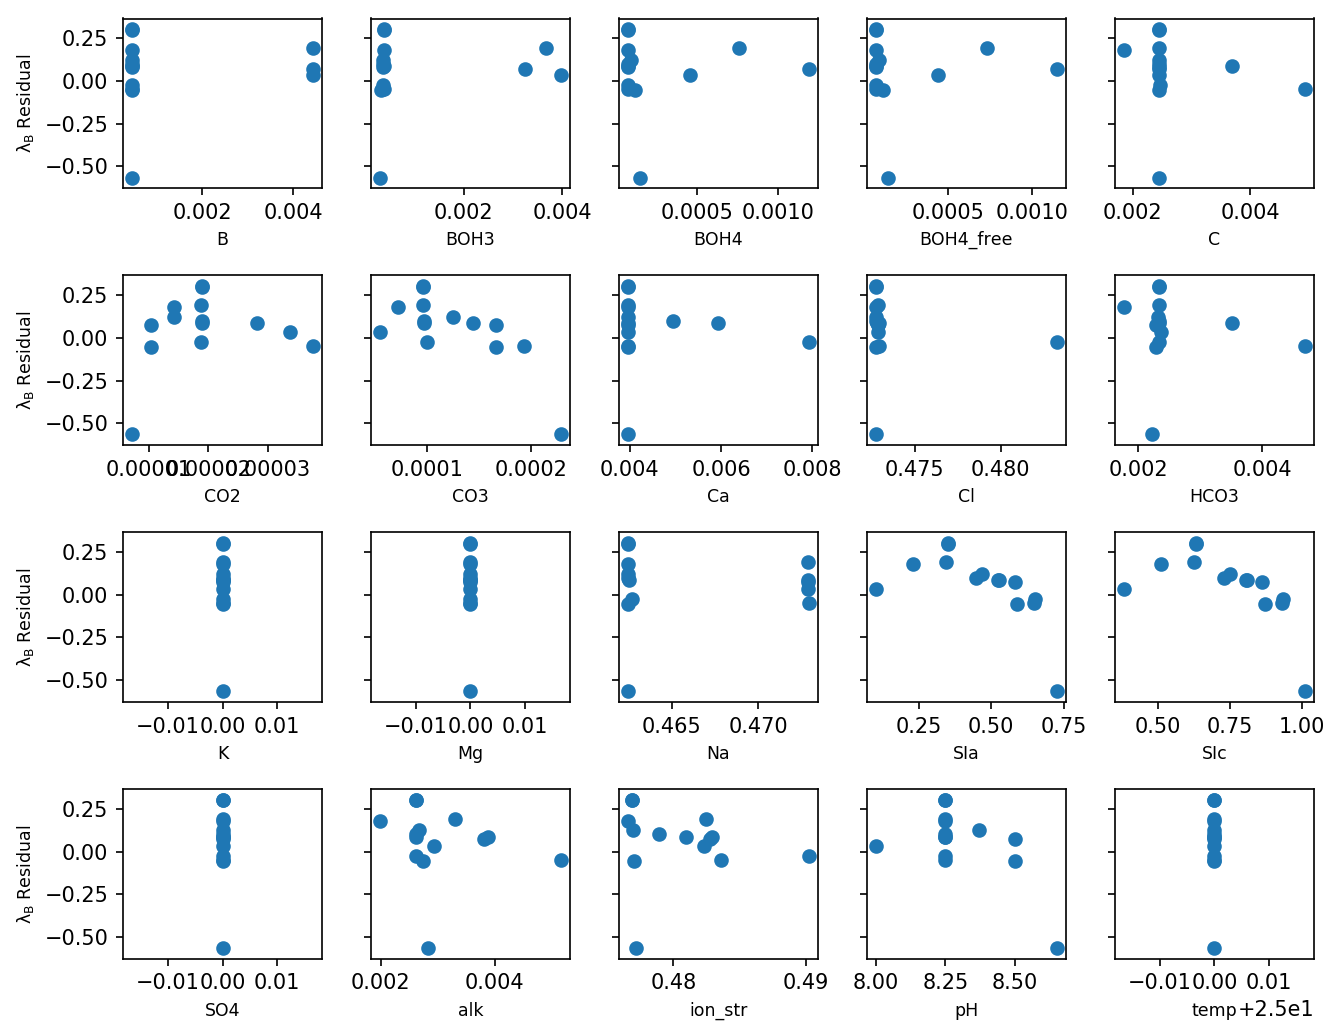

In [97]:
fig, axs = plt.subplots(4, 5, figsize=[9,7], sharey=True)

LambdaB_pred, EpsilonB_pred = predfn(*fit.x, Rp=Rp, rL3=rL3, rL4=rL4, B_DIC=B_DIC, ABO3=ABO3, ABO4=ABO4, dBO4=dBO4)

resid = LambdaB_pred - LambdaB

for c, ax in zip(rd.pitzer.columns, axs.flat):
    x = rd.loc[cind, ('pitzer', c)]
    
    ax.scatter(x, resid)
    ax.set_xlabel(c)
    
    if x.ptp() > 0:
        pad = x.ptp() * 0.05
        ax.set_xlim(x.min() - pad, x.max() + pad)
    
    if ax.is_first_col():
        ax.set_ylabel('$\lambda_B$ Residual')

fig.tight_layout()

Text(0,0.5,'$\\lambda_B$ Residual')

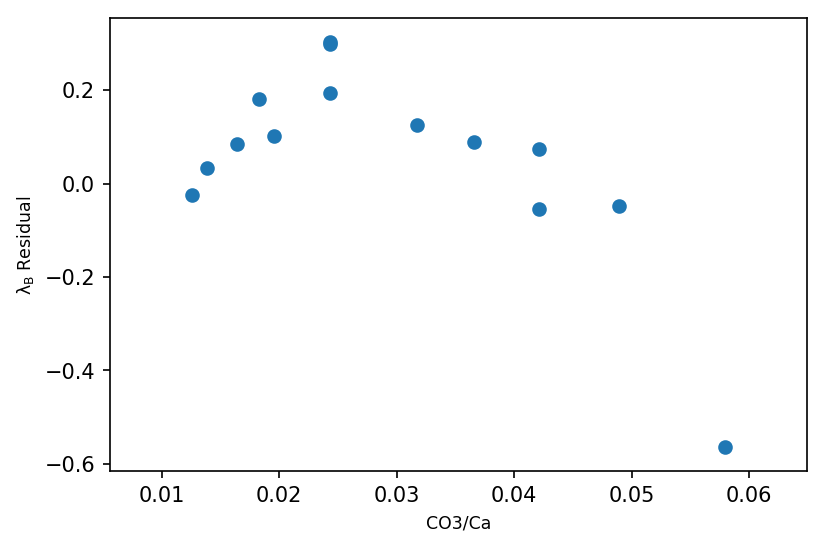

In [98]:
x = rd.loc[cind, ('pitzer', 'CO3')] / rd.loc[cind, ('pitzer', 'Ca')]

plt.scatter(x, resid)
plt.xlabel('CO3/Ca')
plt.ylabel('$\lambda_B$ Residual')